In [10]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

from pinballrt.sources import Star
from pinballrt.grids import UniformCartesianGrid, UniformSphericalGrid
from pinballrt.model import Model
from pinballrt.densities.flared_disk import FlaredDisk
from matplotlib.colors import LogNorm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
star = Star()
star.set_blackbody_spectrum()
disk = FlaredDisk()

In [12]:
model = Model(grid=UniformCartesianGrid, grid_kwargs={"ncells": (24, 24, 24), "dx": 4*u.au})

In [14]:
model.add_component(disk, 'yso.dst')
model.add_star(star)

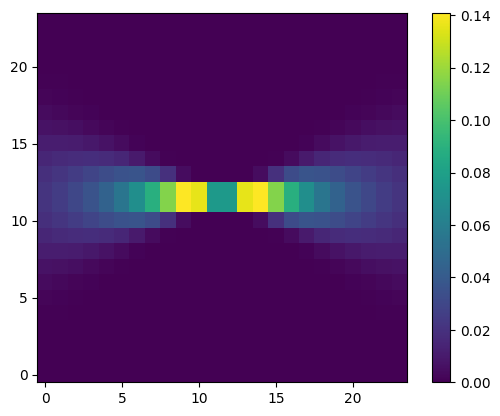

In [15]:
density = model.grid.grid.density.numpy()


plt.imshow(np.transpose(density[10,:,:]), origin='lower')
plt.colorbar()
plt.show()

In [17]:
model.thermal_mc(nphotons=1000000, device="cuda")

Iteration 0
Module pinballrt.grids 89166ee load on device 'cuda:0' took 3.92 ms  (cached)


100%|██████████| 1000000/1000000 [00:00<00:00, 4926523.31it/s]
/home/bdrechsler/Code/pinball-rt/pinballrt/grids.py:379: RuntimeWarning: invalid value encountered in divide
  temperature = ((total_energy*u.L_sun).cgs.value / (4*const.sigma_sb.cgs.value*\


0
Iteration 1


100%|██████████| 1000000/1000000 [00:00<00:00, 7847771.01it/s]


1
Iteration 2


100%|██████████| 1000000/1000000 [00:00<00:00, 7362819.93it/s]


2 1.0698578 1.5078328
Iteration 3


100%|██████████| 1000000/1000000 [00:00<00:00, 7245474.93it/s]

3 1.0594971 1.0097789


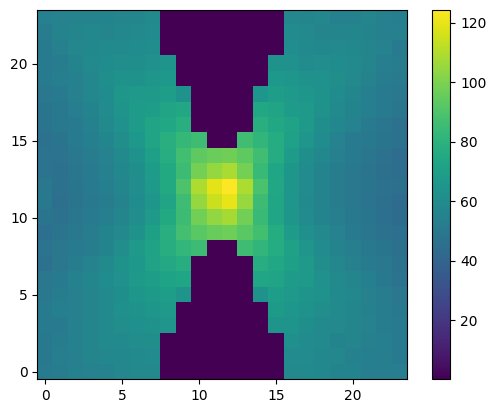

In [31]:
temp = model.grid.grid.temperature.numpy()

plt.imshow(np.transpose(temp[10,:,:]), origin='lower')
plt.colorbar()
plt.show()

In [ ]:
img = model.make_image(npix=100, distance=1*u.pc, pixel_size=2*u.arcsec, lam=np.array([4, 1000])*u.um, incl=85*u.deg, pa=0*u.deg, device='cuda')

/home/bdrechsler/miniconda3/envs/pinball/lib/python3.11/site-packages/astropy/units/quantity.py:648: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
100%|██████████| 100000/100000 [00:00<00:00, 2017316.69it/s]


Time: 1.7715048789978027


100%|██████████| 100000/100000 [00:00<00:00, 3672191.77it/s]


Time: 1.7791454792022705
10000
Module pinballrt.camera 746bad4 load on device 'cuda:0' took 327.91 ms  (compiled)


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [35]:
img = model.make_image(npix=50, distance=1*u.pc, pixel_size=2*u.arcsec, lam=np.array([4, 1000])*u.um, incl=80*u.deg, pa=0*u.deg, device='cpu')


100%|██████████| 100000/100000 [00:00<00:00, 230994.28it/s]


Time: 2.162278652191162


100%|██████████| 100000/100000 [00:00<00:00, 312233.00it/s]

Time: 2.034531831741333
2500


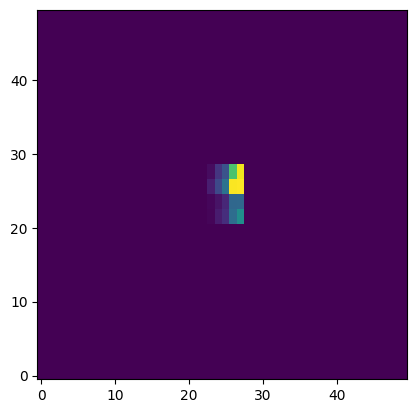

In [36]:
plt.imshow(img.intensity[:,:,0], origin='lower')
plt.show()

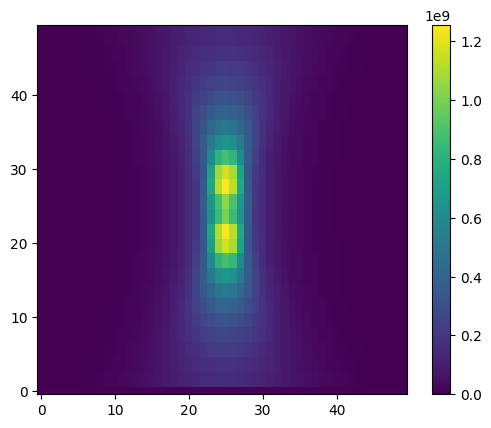

In [37]:
plt.imshow(img.intensity[:,:,1], origin='lower')
plt.colorbar()
plt.show()